In [141]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

In [142]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [143]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [144]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:32<00:00, 434.92it/s]
INFO:root:Read in 52.39935874938965 seconds


In [145]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [146]:
df[0].head(5)

,H_acc,V_acc,rul,unit
0,0.552,-0.146,28029,1_1
1,0.501,-0.480,28029,1_1
2,0.138,0.435,28029,1_1
3,-0.423,0.240,28029,1_1
4,-0.802,0.020,28029,1_1


In [147]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [148]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [149]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,H_acc,V_acc,rul,unit
0,0.552,-0.146,28029,1_1
1,0.501,-0.480,28029,1_1
2,0.138,0.435,28029,1_1
3,-0.423,0.240,28029,1_1
4,-0.802,0.020,28029,1_1
...,...,...,...,...
7175675,-3.353,2.129,0,1_1
7175676,-2.868,-2.299,0,1_1
7175677,-5.507,-1.844,0,1_1
7175678,-3.578,2.146,0,1_1


In [150]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,H_acc,V_acc,rul,unit
0,0.092,0.044,23749,1_3
1,-0.025,0.432,23749,1_3
2,-0.104,0.008,23749,1_3
3,0.056,-0.264,23749,1_3
4,0.074,-0.195,23749,1_3
...,...,...,...,...
3845115,0.481,-0.013,7570,1_7
3845116,0.191,-0.272,7570,1_7
3845117,0.250,0.466,7570,1_7
3845118,0.001,-0.582,7570,1_7


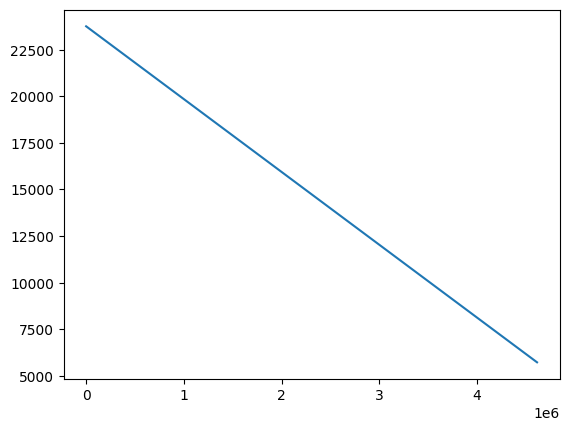

In [151]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [152]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [153]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # vib_h = df['H_acc'].values
        # vib_v = df['V_acc'].values
        # rul = df['rul'].values
        rul = df.groupby('unit')['rul'].transform(
            lambda x: x / x.max()
            # lambda x: x
        ).values
        # max_rul = max(rul)
        
        # Normalize per bearing
        # vib_h = (vib_h - vib_h.mean()) / (vib_h.std() + 1e-8)
        # vib_v = (vib_v - vib_v.mean()) / (vib_v.std() + 1e-8)

        vib_h = df.groupby('unit')['H_acc'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )
        vib_v = df.groupby('unit')['V_acc'].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)
        )
        
        # Create sequences
        for i in range(0, len(df) - window_size, step):
            self.windows.append(np.stack([vib_h[i:i+window_size], 
                                        vib_v[i:i+window_size]], axis=1))
            self.ruls.append(rul[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_4'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [154]:
train_dataset[0][0].shape

torch.Size([2560, 2])

In [155]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1)
            # Removed Sigmoid() for regression
        )
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        return self.regressor(x).squeeze()  # -> (B,)

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)

            # if y_pred.size(0) > 1:
            #     sorted_pred, _ = torch.sort(y_pred.squeeze(), descending=True)
            #     mono_loss = torch.relu(sorted_pred[1:] - sorted_pred[:-1]).mean()
            #     loss += 0.1 * mono_loss
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        # epoch_train_eps = early_prediction_score(train_targets, train_preds)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        # train_eps.append(epoch_train_eps)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [157]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 30)

train_results

  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:03<00:00, 47.92it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 48.03it/s]


Epoch 1: Train Loss 0.0280, Train R2 = 0.663, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.099


Epoch 1 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 Val:  83%|████████▎ | 60/72 [00:00<00:00, 196.64it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 Val: 100%|██████████| 72/72 [00:00<00:00, 197.29it/s]


Epoch 1: Val Loss 0.3497, Val R2 = -3.511, Val RMSE = 0.595, Val MSE = 0.354, Val MAE = 0.524


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 48.93it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 48.84it/s]


Epoch 2: Train Loss 0.0320, Train R2 = 0.614, Train RMSE = 0.179, Train MSE = 0.032, Train MAE = 0.097


Epoch 2 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2 Val:  83%|████████▎ | 60/72 [00:00<00:00, 195.00it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2 Val: 100%|██████████| 72/72 [00:00<00:00, 197.37it/s]


Epoch 2: Val Loss 0.3703, Val R2 = -3.778, Val RMSE = 0.612, Val MSE = 0.375, Val MAE = 0.543


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:03<00:00, 52.18it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.19it/s]


Epoch 3: Train Loss 0.0376, Train R2 = 0.546, Train RMSE = 0.194, Train MSE = 0.038, Train MAE = 0.104


Epoch 3 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3 Val:  88%|████████▊ | 63/72 [00:00<00:00, 204.96it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3 Val: 100%|██████████| 72/72 [00:00<00:00, 206.37it/s]


Epoch 3: Val Loss 0.3811, Val R2 = -3.917, Val RMSE = 0.621, Val MSE = 0.386, Val MAE = 0.553


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 52.07it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 52.30it/s]


Epoch 4: Train Loss 0.0390, Train R2 = 0.530, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.107


Epoch 4 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4 Val:  88%|████████▊ | 63/72 [00:00<00:00, 202.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4 Val: 100%|██████████| 72/72 [00:00<00:00, 203.88it/s]


Epoch 4: Val Loss 0.3532, Val R2 = -3.557, Val RMSE = 0.598, Val MSE = 0.358, Val MAE = 0.526


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 51.93it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 51.96it/s]


Epoch 5: Train Loss 0.0400, Train R2 = 0.518, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.109


Epoch 5 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5 Val:  88%|████████▊ | 63/72 [00:00<00:00, 204.91it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5 Val: 100%|██████████| 72/72 [00:00<00:00, 205.93it/s]


Epoch 5: Val Loss 0.3214, Val R2 = -3.146, Val RMSE = 0.570, Val MSE = 0.325, Val MAE = 0.497


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 51.69it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 51.77it/s]


Epoch 6: Train Loss 0.0404, Train R2 = 0.512, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.108


Epoch 6 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6 Val:  88%|████████▊ | 63/72 [00:00<00:00, 201.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6 Val: 100%|██████████| 72/72 [00:00<00:00, 203.65it/s]


Epoch 6: Val Loss 0.2914, Val R2 = -2.760, Val RMSE = 0.543, Val MSE = 0.295, Val MAE = 0.467


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 51.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 51.57it/s]


Epoch 7: Train Loss 0.0433, Train R2 = 0.478, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.112


Epoch 7 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7 Val:  88%|████████▊ | 63/72 [00:00<00:00, 204.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7 Val: 100%|██████████| 72/72 [00:00<00:00, 204.89it/s]


Epoch 7: Val Loss 0.3040, Val R2 = -2.922, Val RMSE = 0.555, Val MSE = 0.308, Val MAE = 0.479


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 51.27it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 51.39it/s]


Epoch 8: Train Loss 0.0426, Train R2 = 0.485, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.112


Epoch 8 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8 Val:  88%|████████▊ | 63/72 [00:00<00:00, 202.52it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8 Val: 100%|██████████| 72/72 [00:00<00:00, 203.66it/s]


Epoch 8: Val Loss 0.3149, Val R2 = -3.062, Val RMSE = 0.565, Val MSE = 0.319, Val MAE = 0.491


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 51.42it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 51.54it/s]


Epoch 9: Train Loss 0.0454, Train R2 = 0.452, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.116


Epoch 9 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9 Val:  88%|████████▊ | 63/72 [00:00<00:00, 197.54it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9 Val: 100%|██████████| 72/72 [00:00<00:00, 199.70it/s]


Epoch 9: Val Loss 0.3267, Val R2 = -3.215, Val RMSE = 0.575, Val MSE = 0.331, Val MAE = 0.501


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 50.93it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.91it/s]


Epoch 10: Train Loss 0.0471, Train R2 = 0.432, Train RMSE = 0.218, Train MSE = 0.047, Train MAE = 0.121


Epoch 10 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10 Val:  88%|████████▊ | 63/72 [00:00<00:00, 200.46it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10 Val: 100%|██████████| 72/72 [00:00<00:00, 202.74it/s]


Epoch 10: Val Loss 0.3388, Val R2 = -3.371, Val RMSE = 0.586, Val MSE = 0.343, Val MAE = 0.513


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 50.95it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.70it/s]


Epoch 11: Train Loss 0.0511, Train R2 = 0.384, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.126


Epoch 11 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11 Val:  88%|████████▊ | 63/72 [00:00<00:00, 203.08it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11 Val: 100%|██████████| 72/72 [00:00<00:00, 203.44it/s]


Epoch 11: Val Loss 0.2601, Val R2 = -2.356, Val RMSE = 0.513, Val MSE = 0.263, Val MAE = 0.433


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 50.50it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.76it/s]


Epoch 12: Train Loss 0.0470, Train R2 = 0.433, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.122


Epoch 12 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12 Val:  88%|████████▊ | 63/72 [00:00<00:00, 200.74it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12 Val: 100%|██████████| 72/72 [00:00<00:00, 202.65it/s]


Epoch 12: Val Loss 0.2603, Val R2 = -2.358, Val RMSE = 0.513, Val MSE = 0.263, Val MAE = 0.434


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 170/176 [00:03<00:00, 49.80it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.34it/s]


Epoch 13: Train Loss 0.0545, Train R2 = 0.343, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.133


Epoch 13 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13 Val:  88%|████████▊ | 63/72 [00:00<00:00, 201.39it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13 Val: 100%|██████████| 72/72 [00:00<00:00, 202.35it/s]


Epoch 13: Val Loss 0.2044, Val R2 = -1.636, Val RMSE = 0.455, Val MSE = 0.207, Val MAE = 0.365


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:03<00:00, 49.17it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 50.26it/s]


Epoch 14: Train Loss 0.0505, Train R2 = 0.391, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.136


Epoch 14 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14 Val:  86%|████████▌ | 62/72 [00:00<00:00, 200.15it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14 Val: 100%|██████████| 72/72 [00:00<00:00, 201.07it/s]


Epoch 14: Val Loss 0.2896, Val R2 = -2.735, Val RMSE = 0.541, Val MSE = 0.293, Val MAE = 0.467


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 171/176 [00:03<00:00, 49.04it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 49.83it/s]


Epoch 15: Train Loss 0.0588, Train R2 = 0.290, Train RMSE = 0.243, Train MSE = 0.059, Train MAE = 0.144


Epoch 15 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15 Val:  83%|████████▎ | 60/72 [00:00<00:00, 197.33it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15 Val: 100%|██████████| 72/72 [00:00<00:00, 198.89it/s]


Epoch 15: Val Loss 0.2687, Val R2 = -2.465, Val RMSE = 0.521, Val MSE = 0.272, Val MAE = 0.445


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 47.86it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 48.12it/s]


Epoch 16: Train Loss 0.0610, Train R2 = 0.265, Train RMSE = 0.247, Train MSE = 0.061, Train MAE = 0.146


Epoch 16 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16 Val:  85%|████████▍ | 61/72 [00:00<00:00, 200.12it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16 Val: 100%|██████████| 72/72 [00:00<00:00, 200.95it/s]


Epoch 16: Val Loss 0.2944, Val R2 = -2.798, Val RMSE = 0.546, Val MSE = 0.298, Val MAE = 0.470


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 47.04it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 47.46it/s]


Epoch 17: Train Loss 0.0519, Train R2 = 0.375, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.134


Epoch 17 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17 Val:  83%|████████▎ | 60/72 [00:00<00:00, 196.70it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17 Val: 100%|██████████| 72/72 [00:00<00:00, 197.85it/s]


Epoch 17: Val Loss 0.3033, Val R2 = -2.911, Val RMSE = 0.554, Val MSE = 0.307, Val MAE = 0.481


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 45.62it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 45.84it/s]


Epoch 18: Train Loss 0.0404, Train R2 = 0.514, Train RMSE = 0.201, Train MSE = 0.041, Train MAE = 0.122


Epoch 18 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18 Val:  82%|████████▏ | 59/72 [00:00<00:00, 193.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18 Val: 100%|██████████| 72/72 [00:00<00:00, 193.86it/s]


Epoch 18: Val Loss 0.3006, Val R2 = -2.878, Val RMSE = 0.552, Val MSE = 0.304, Val MAE = 0.483


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 45.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 45.77it/s]


Epoch 19: Train Loss 0.0391, Train R2 = 0.529, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.123


Epoch 19 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19 Val:  83%|████████▎ | 60/72 [00:00<00:00, 191.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19 Val: 100%|██████████| 72/72 [00:00<00:00, 191.88it/s]


Epoch 19: Val Loss 0.3444, Val R2 = -3.443, Val RMSE = 0.590, Val MSE = 0.349, Val MAE = 0.518


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:04<00:00, 42.70it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 43.55it/s]


Epoch 20: Train Loss 0.0578, Train R2 = 0.303, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.138


Epoch 20 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20 Val:  81%|████████  | 58/72 [00:00<00:00, 188.86it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20 Val: 100%|██████████| 72/72 [00:00<00:00, 188.22it/s]


Epoch 20: Val Loss 0.3275, Val R2 = -3.225, Val RMSE = 0.576, Val MSE = 0.331, Val MAE = 0.501


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:04<00:00, 41.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 40.56it/s]


Epoch 21: Train Loss 0.0446, Train R2 = 0.462, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.133


Epoch 21 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21 Val:  99%|█████████▊| 71/72 [00:00<00:00, 175.95it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21 Val: 100%|██████████| 72/72 [00:00<00:00, 175.70it/s]


Epoch 21: Val Loss 0.2656, Val R2 = -2.425, Val RMSE = 0.518, Val MSE = 0.269, Val MAE = 0.441


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:04<00:00, 39.00it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 39.17it/s]


Epoch 22: Train Loss 0.0626, Train R2 = 0.245, Train RMSE = 0.251, Train MSE = 0.063, Train MAE = 0.156


Epoch 22 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22 Val:  96%|█████████▌| 69/72 [00:00<00:00, 162.29it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22 Val: 100%|██████████| 72/72 [00:00<00:00, 165.07it/s]


Epoch 22: Val Loss 0.2862, Val R2 = -2.692, Val RMSE = 0.538, Val MSE = 0.290, Val MAE = 0.464


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.49it/s]


Epoch 23: Train Loss 0.0491, Train R2 = 0.409, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.134


Epoch 23 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23 Val:  89%|████████▉ | 64/72 [00:00<00:00, 153.96it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23 Val: 100%|██████████| 72/72 [00:00<00:00, 155.03it/s]


Epoch 23: Val Loss 0.1434, Val R2 = -0.846, Val RMSE = 0.381, Val MSE = 0.145, Val MAE = 0.312


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.67it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.71it/s]


Epoch 24: Train Loss 0.0393, Train R2 = 0.526, Train RMSE = 0.199, Train MSE = 0.039, Train MAE = 0.131


Epoch 24 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.76it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24 Val: 100%|██████████| 72/72 [00:00<00:00, 156.53it/s]


Epoch 24: Val Loss 0.2883, Val R2 = -2.718, Val RMSE = 0.540, Val MSE = 0.292, Val MAE = 0.466


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.45it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.70it/s]


Epoch 25: Train Loss 0.0475, Train R2 = 0.428, Train RMSE = 0.218, Train MSE = 0.048, Train MAE = 0.134


Epoch 25 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.89it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25 Val: 100%|██████████| 72/72 [00:00<00:00, 157.10it/s]


Epoch 25: Val Loss 0.1781, Val R2 = -1.296, Val RMSE = 0.424, Val MSE = 0.180, Val MAE = 0.353


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.43it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.70it/s]


Epoch 26: Train Loss 0.0401, Train R2 = 0.516, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.136


Epoch 26 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 26 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.62it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 26 Val: 100%|██████████| 72/72 [00:00<00:00, 156.62it/s]


Epoch 26: Val Loss 0.2457, Val R2 = -2.169, Val RMSE = 0.499, Val MSE = 0.249, Val MAE = 0.418


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.69it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.63it/s]


Epoch 27: Train Loss 0.0631, Train R2 = 0.240, Train RMSE = 0.252, Train MSE = 0.063, Train MAE = 0.162


Epoch 27 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 27 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 27 Val: 100%|██████████| 72/72 [00:00<00:00, 156.71it/s]


Epoch 27: Val Loss 0.4293, Val R2 = -4.535, Val RMSE = 0.659, Val MSE = 0.434, Val MAE = 0.613


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.51it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.66it/s]


Epoch 28: Train Loss 0.0549, Train R2 = 0.340, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.142


Epoch 28 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 28 Val:  89%|████████▉ | 64/72 [00:00<00:00, 152.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 28 Val: 100%|██████████| 72/72 [00:00<00:00, 154.81it/s]


Epoch 28: Val Loss 0.0704, Val R2 = 0.103, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.229


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 37.26it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.22it/s]


Epoch 29: Train Loss 0.0352, Train R2 = 0.576, Train RMSE = 0.188, Train MSE = 0.035, Train MAE = 0.120


Epoch 29 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 29 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.99it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 29 Val: 100%|██████████| 72/72 [00:00<00:00, 156.88it/s]


Epoch 29: Val Loss 0.1607, Val R2 = -1.071, Val RMSE = 0.403, Val MSE = 0.163, Val MAE = 0.328


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 37.45it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 37.50it/s]


Epoch 30: Train Loss 0.0338, Train R2 = 0.593, Train RMSE = 0.184, Train MSE = 0.034, Train MAE = 0.107


Epoch 30 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 30 Val:  89%|████████▉ | 64/72 [00:00<00:00, 153.63it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 30 Val: 100%|██████████| 72/72 [00:00<00:00, 154.89it/s]


Epoch 30: Val Loss 0.3357, Val R2 = -3.330, Val RMSE = 0.583, Val MSE = 0.340, Val MAE = 0.519


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:04<00:00, 40.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.37it/s]


Epoch 31: Train Loss 0.0276, Train R2 = 0.667, Train RMSE = 0.167, Train MSE = 0.028, Train MAE = 0.103


Epoch 31 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 31 Val:  94%|█████████▍| 68/72 [00:00<00:00, 166.13it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 31 Val: 100%|██████████| 72/72 [00:00<00:00, 166.13it/s]


Epoch 31: Val Loss 0.0878, Val R2 = -0.130, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.246


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 39.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 39.13it/s]


Epoch 32: Train Loss 0.0244, Train R2 = 0.705, Train RMSE = 0.157, Train MSE = 0.025, Train MAE = 0.097


Epoch 32 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 32 Val:  92%|█████████▏| 66/72 [00:00<00:00, 160.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 32 Val: 100%|██████████| 72/72 [00:00<00:00, 160.47it/s]


Epoch 32: Val Loss 0.3911, Val R2 = -4.044, Val RMSE = 0.629, Val MSE = 0.396, Val MAE = 0.564


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 35.94it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 37.77it/s]


Epoch 33: Train Loss 0.0220, Train R2 = 0.736, Train RMSE = 0.148, Train MSE = 0.022, Train MAE = 0.088


Epoch 33 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 33 Val:  88%|████████▊ | 63/72 [00:00<00:00, 152.77it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 33 Val: 100%|██████████| 72/72 [00:00<00:00, 153.32it/s]


Epoch 33: Val Loss 0.0648, Val R2 = 0.164, Val RMSE = 0.256, Val MSE = 0.066, Val MAE = 0.218


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 34.87it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 34.85it/s]


Epoch 34: Train Loss 0.0203, Train R2 = 0.755, Train RMSE = 0.143, Train MSE = 0.020, Train MAE = 0.080


Epoch 34 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 34 Val:  86%|████████▌ | 62/72 [00:00<00:00, 146.18it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 34 Val: 100%|██████████| 72/72 [00:00<00:00, 147.54it/s]


Epoch 34: Val Loss 0.1666, Val R2 = -1.132, Val RMSE = 0.409, Val MSE = 0.167, Val MAE = 0.346


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 34.44it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 34.48it/s]


Epoch 35: Train Loss 0.0166, Train R2 = 0.801, Train RMSE = 0.129, Train MSE = 0.017, Train MAE = 0.075


Epoch 35 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 35 Val:  89%|████████▉ | 64/72 [00:00<00:00, 150.81it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 35 Val: 100%|██████████| 72/72 [00:00<00:00, 152.58it/s]


Epoch 35: Val Loss 0.1030, Val R2 = -0.326, Val RMSE = 0.323, Val MSE = 0.104, Val MAE = 0.267


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 33.89it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 33.91it/s]


Epoch 36: Train Loss 0.0176, Train R2 = 0.788, Train RMSE = 0.133, Train MSE = 0.018, Train MAE = 0.074


Epoch 36 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 36 Val:  83%|████████▎ | 60/72 [00:00<00:00, 147.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 36 Val: 100%|██████████| 72/72 [00:00<00:00, 148.31it/s]


Epoch 36: Val Loss 0.3391, Val R2 = -3.364, Val RMSE = 0.585, Val MSE = 0.342, Val MAE = 0.527


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 35.74it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 35.01it/s]


Epoch 37: Train Loss 0.0122, Train R2 = 0.853, Train RMSE = 0.110, Train MSE = 0.012, Train MAE = 0.072


Epoch 37 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 37 Val:  89%|████████▉ | 64/72 [00:00<00:00, 156.05it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 37 Val: 100%|██████████| 72/72 [00:00<00:00, 156.45it/s]


Epoch 37: Val Loss 0.0914, Val R2 = -0.179, Val RMSE = 0.304, Val MSE = 0.093, Val MAE = 0.251


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 33.53it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 33.62it/s]


Epoch 38: Train Loss 0.0189, Train R2 = 0.772, Train RMSE = 0.138, Train MSE = 0.019, Train MAE = 0.084


Epoch 38 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 38 Val:  83%|████████▎ | 60/72 [00:00<00:00, 143.73it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 38 Val: 100%|██████████| 72/72 [00:00<00:00, 145.55it/s]


Epoch 38: Val Loss 0.0872, Val R2 = -0.118, Val RMSE = 0.296, Val MSE = 0.088, Val MAE = 0.247


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 33.40it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 33.66it/s]


Epoch 39: Train Loss 0.0223, Train R2 = 0.732, Train RMSE = 0.150, Train MSE = 0.022, Train MAE = 0.091


Epoch 39 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 39 Val:  83%|████████▎ | 60/72 [00:00<00:00, 145.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 39 Val: 100%|██████████| 72/72 [00:00<00:00, 148.42it/s]


Epoch 39: Val Loss 0.2801, Val R2 = -2.610, Val RMSE = 0.532, Val MSE = 0.283, Val MAE = 0.467


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.58it/s]


Epoch 40: Train Loss 0.0159, Train R2 = 0.808, Train RMSE = 0.126, Train MSE = 0.016, Train MAE = 0.079


Epoch 40 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 40 Val:  82%|████████▏ | 59/72 [00:00<00:00, 142.74it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 40 Val: 100%|██████████| 72/72 [00:00<00:00, 143.67it/s]


Epoch 40: Val Loss 0.1630, Val R2 = -1.033, Val RMSE = 0.399, Val MSE = 0.159, Val MAE = 0.331


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.24it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.51it/s]


Epoch 41: Train Loss 0.0229, Train R2 = 0.724, Train RMSE = 0.152, Train MSE = 0.023, Train MAE = 0.087


Epoch 41 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 41 Val:  83%|████████▎ | 60/72 [00:00<00:00, 142.67it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 41 Val: 100%|██████████| 72/72 [00:00<00:00, 144.17it/s]


Epoch 41: Val Loss 0.1085, Val R2 = -0.367, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.275


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.29it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.36it/s]


Epoch 42: Train Loss 0.0181, Train R2 = 0.782, Train RMSE = 0.135, Train MSE = 0.018, Train MAE = 0.083


Epoch 42 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 42 Val:  81%|████████  | 58/72 [00:00<00:00, 142.57it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 42 Val: 100%|██████████| 72/72 [00:00<00:00, 142.75it/s]


Epoch 42: Val Loss 0.4178, Val R2 = -4.341, Val RMSE = 0.647, Val MSE = 0.419, Val MAE = 0.586


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.05it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.32it/s]


Epoch 43: Train Loss 0.0101, Train R2 = 0.878, Train RMSE = 0.101, Train MSE = 0.010, Train MAE = 0.069


Epoch 43 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 43 Val:  83%|████████▎ | 60/72 [00:00<00:00, 143.59it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 43 Val: 100%|██████████| 72/72 [00:00<00:00, 144.49it/s]


Epoch 43: Val Loss 0.1780, Val R2 = -1.294, Val RMSE = 0.424, Val MSE = 0.180, Val MAE = 0.365


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.29it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.19it/s]


Epoch 44: Train Loss 0.0150, Train R2 = 0.819, Train RMSE = 0.123, Train MSE = 0.015, Train MAE = 0.084


Epoch 44 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 44 Val:  83%|████████▎ | 60/72 [00:00<00:00, 143.02it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 44 Val: 100%|██████████| 72/72 [00:00<00:00, 143.90it/s]


Epoch 44: Val Loss 0.2064, Val R2 = -1.651, Val RMSE = 0.456, Val MSE = 0.208, Val MAE = 0.387


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 30.86it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 31.95it/s]


Epoch 45: Train Loss 0.0143, Train R2 = 0.829, Train RMSE = 0.119, Train MSE = 0.014, Train MAE = 0.075


Epoch 45 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 45 Val:  99%|█████████▊| 71/72 [00:00<00:00, 137.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 45 Val: 100%|██████████| 72/72 [00:00<00:00, 138.62it/s]


Epoch 45: Val Loss 0.0799, Val R2 = -0.011, Val RMSE = 0.282, Val MSE = 0.079, Val MAE = 0.243


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 30.91it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 31.28it/s]


Epoch 46: Train Loss 0.0134, Train R2 = 0.838, Train RMSE = 0.116, Train MSE = 0.014, Train MAE = 0.078


Epoch 46 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 46 Val:  99%|█████████▊| 71/72 [00:00<00:00, 139.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 46 Val: 100%|██████████| 72/72 [00:00<00:00, 139.42it/s]


Epoch 46: Val Loss 0.1263, Val R2 = -0.628, Val RMSE = 0.357, Val MSE = 0.128, Val MAE = 0.292


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 31.15it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 31.35it/s]


Epoch 47: Train Loss 0.0168, Train R2 = 0.798, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.083


Epoch 47 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 47 Val:  83%|████████▎ | 60/72 [00:00<00:00, 141.61it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 47 Val: 100%|██████████| 72/72 [00:00<00:00, 141.95it/s]


Epoch 47: Val Loss 0.3790, Val R2 = -3.883, Val RMSE = 0.619, Val MSE = 0.383, Val MAE = 0.573


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 31.11it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 31.17it/s]


Epoch 48: Train Loss 0.0123, Train R2 = 0.851, Train RMSE = 0.111, Train MSE = 0.012, Train MAE = 0.075


Epoch 48 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 48 Val:  79%|███████▉  | 57/72 [00:00<00:00, 136.50it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 48 Val: 100%|██████████| 72/72 [00:00<00:00, 138.06it/s]


Epoch 48: Val Loss 0.4282, Val R2 = -4.495, Val RMSE = 0.657, Val MSE = 0.431, Val MAE = 0.614


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:05<00:00, 29.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.47it/s]


Epoch 49: Train Loss 0.0087, Train R2 = 0.895, Train RMSE = 0.093, Train MSE = 0.009, Train MAE = 0.066


Epoch 49 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 49 Val:  82%|████████▏ | 59/72 [00:00<00:00, 138.45it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 49 Val: 100%|██████████| 72/72 [00:00<00:00, 139.86it/s]


Epoch 49: Val Loss 0.1654, Val R2 = -1.101, Val RMSE = 0.406, Val MSE = 0.165, Val MAE = 0.341


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 30.43it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.48it/s]


Epoch 50: Train Loss 0.0087, Train R2 = 0.895, Train RMSE = 0.094, Train MSE = 0.009, Train MAE = 0.066


Epoch 50 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50 Val:  97%|█████████▋| 70/72 [00:00<00:00, 134.67it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50 Val: 100%|██████████| 72/72 [00:00<00:00, 135.92it/s]

Epoch 50: Val Loss 0.0817, Val R2 = -0.021, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.242


{'train_loss': [0.02797950421915051,
  0.03201831296279455,
  0.037649798509929416,
  0.03898917821193622,
  0.039968080968140966,
  0.04042086902667175,
  0.04327918222406879,
  0.04264317341287758,
  0.0454373570127328,
  0.047114427892665844,
  0.05106930087045343,
  0.047032686502048324,
  0.0544569062397138,
  0.05047989786279769,
  0.05882867029735776,
  0.060955385267417034,
  0.05185366598280697,
  0.04040168641553133,
  0.039085774136103944,
  0.05775817104983038,
  0.04460245267149399,
  0.06255174011642918,
  0.0490660476200653,
  0.03933076817404733,
  0.04748561724607663,
  0.040120186310642486,
  0.0630639516695572,
  0.05493204757063226,
  0.03517197256025446,
  0.03375542559826334,
  0.027630612967517332,
  0.024446886918502223,
  0.02197485411968294,
  0.020332185961954317,
  0.016569306176362177,
  0.017581696873424913,
  0.01215588196505864,
  0.018895518798341403,
  0.022272114271552047,
  0.015916132693581112,
  0.02290090349627214,
  0.01809278388629371,
  0.01011

In [160]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



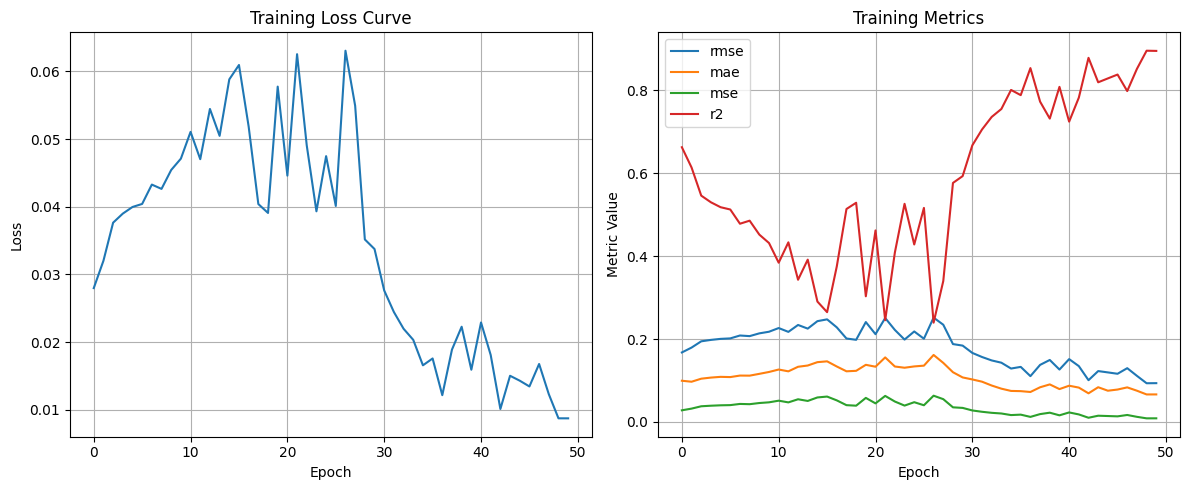

In [161]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [162]:
len(test_loader)

113

In [163]:
def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    # test_eps = []
    

    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            # time_frac = torch.linspace(0, 1, steps=labels.shape[0]).unsqueeze(1).to(device)
            data = data.to(device)
            labels = labels.to(device)
            # print(time_frac.shape, "SHAPE X", data.shape)
            predictions = model(data).flatten()
            
            predictions =  torch.cummin(predictions.flip(0), dim=0).values.flip(0)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))
        # test_eps.append(early_prediction_score(test_targets, test_preds))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
        # 'test_eps': test_eps,
    }
          

In [164]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 178.20it/s]


{'test_r2': [-1.1017734292331571],
 'test_mae': [0.2813184],
 'test_mse': [0.10072595],
 'test_rmse': [0.3173735],
 'test_preds': array([0.46276605, 0.46276605, 0.46276605, ..., 0.11795495, 0.11795495,
        0.11814322], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

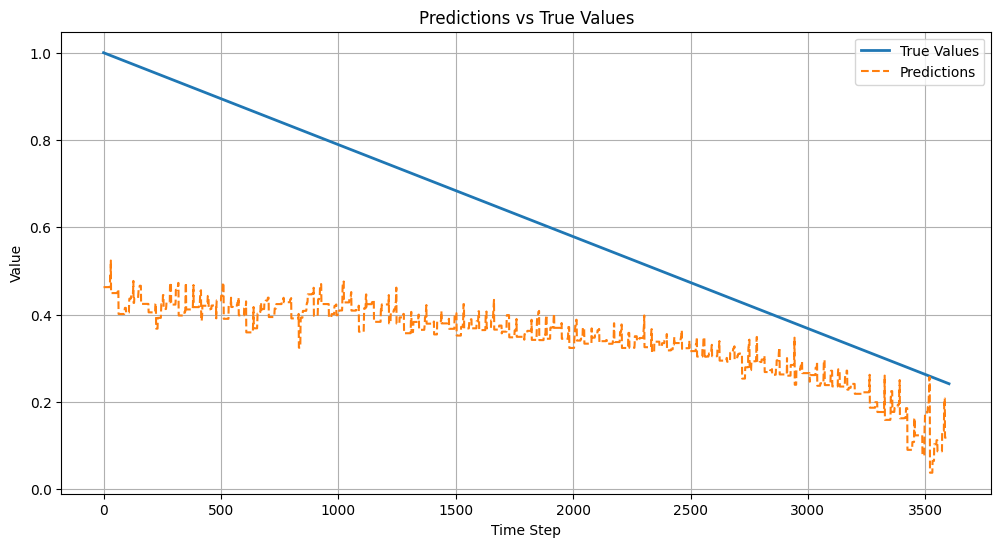

In [165]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [108]:
test_results['test_targets']

array([[0.99957895],
       [0.99936837],
       [0.99915785],
       ...,
       [0.24186282],
       [0.24165228],
       [0.24144174]], dtype=float32)

In [109]:
test_results['test_preds']

array([0.4244091 , 0.4244091 , 0.4244091 , ..., 0.42572862, 0.42628363,
       0.42628363], dtype=float32)